# TO DO
1. Figure out dataset
2. Break down into individual characters
3. Form corpus from dataset for input and output characters
4. Assign a number to each character
5. Model will have an embedding so it will handle it
6. Output will be a bunch of integers so we will have to decode it

In [1]:
import tarfile
import os
import pandas as pd
import keras
import numpy as np
from keras.layers import LSTM, Dense, Embedding, Input
from keras.models import Model
from keras.utils.vis_utils import plot_model

In [2]:
!wget -nc https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

if not os.path.isdir('/content/dakshina_dataset_v1.0'):
  tarfile.open("/content/dakshina_dataset_v1.0.tar").extractall() 

--2021-04-23 07:47:11--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   132MB/s    in 20s     

2021-04-23 07:47:31 (97.1 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



# Loading Data

In [3]:
class data_loader():

  @staticmethod
  def load_devanagiri():
    lex = dict()
    lex['train'], lex['val'], lex['test'] = [], [], [] 
    column_names = ['input', 'output', 'count']

    languages = ['hi', 'mr']
    
    for la in languages:
      lex['train'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.train.tsv', sep='\t', header=None, names=column_names))
      lex['val'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.dev.tsv', sep='\t', header=None, names=column_names))
      lex['test'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.test.tsv', sep='\t', header=None, names=column_names))

    lex['train'] = pd.concat(lex['train'])
    lex['val'] = pd.concat(lex['val'])
    lex['test'] = pd.concat(lex['test'])

    return lex    

  @staticmethod
  def make_dataframe(lex):
    
    for div in ['train', 'val', 'test']:
    
      # removing non max transliterations
      idx = lex[div].groupby(['input'])['count'].transform(max) == lex[div]['count']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # calclulating difference in lengths of various transliterations
      lex[div]['input_len'] = lex[div].apply(lambda x: len(str(x['input'])), axis=1)
      lex[div]['output_len'] = lex[div].apply(lambda y: len(str(y['output'])), axis=1)
      lex[div]['mod_dif'] = lex[div].apply(lambda z: abs(z['input_len'] - z['output_len']), axis=1) 

      # removing transliterations that vary by a lot in length
      idx = lex[div].groupby(['input'])['mod_dif'].transform(min) == lex[div]['mod_dif']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # removing duplicates if any remain
      lex[div].drop_duplicates(subset='input', keep='first', inplace=True)

      # removing redundant columns
      lex[div].drop(labels=['count', 'input_len', 'output_len', 'mod_dif'], inplace=True, axis=1)

    return lex

In [4]:
lex = data_loader.load_devanagiri()
lex = data_loader.make_dataframe(lex)

In [5]:
df = lex['train']

In [6]:
print(df.input.tolist())

['अं', 'अंकगणित', 'अंकल', 'अंकुर', 'अंकुरण', 'अंकुरित', 'अंकुश', 'अंग', 'अंगने', 'अंगभंग', 'अंगरक्षक', 'अंगारा', 'अंगारे', 'अंगी', 'अंगीकार', 'अंगुठे', 'अंगुल', 'अंगुलियों', 'अंगुली', 'अंगूठा', 'अंगूठियों', 'अंगूठी', 'अंगूठे', 'अंगूर', 'अंगूरी', 'अंगूरों', 'अंगों', 'अंगोला', 'अंग्रजी', 'अंग्रेजी', 'अंचल', 'अंचलों', 'अंजन', 'अंजना', 'अंजान', 'अंजानी', 'अंजाने', 'अंजार', 'अंजीर', 'अंजुम', 'अंजुमन', 'अंजू', 'अंटार्कटिका', 'अंटोनियो', 'अंटोनी', 'अंडमान', 'अंडरकवर', 'अंडरटेकर', 'अंडरवर्ल्ड', 'अंडरवियर', 'अंडा', 'अंडाकार', 'अंडाशय', 'अंडों', 'अंत', 'अंतःकरण', 'अंततोगत्वा', 'अंतरग्रहीय', 'अंतरमहाद्वीपीय', 'अंतरराष्ट्रीय', 'अंतरर्राष्ट्रीय', 'अंतरात्मा', 'अंतराल', 'अंतराष्ट्रीय', 'अंतरिक्ष', 'अंतरिक्षयात्री', 'अंतरिक्षयान', 'अंतरिम', 'अंतरों', 'अंतर्गत', 'अंतर्दृष्टि', 'अंतर्देशीय', 'अंतर्निहित', 'अंतर्मन', 'अंतर्राष्ट्रीय', 'अंतर्वस्त्र', 'अंतर्विरोधों', 'अंतर्वैयक्तिक', 'अंतिम', 'अंतुले', 'अंत्य', 'अंत्येष्टि', 'अंत्योदय', 'अंदर', 'अंदरूनी', 'अंदाजन', 'अंदाज़', 'अंदाजा', 'अंदेशा', 'अंधक', 'अ

# Dataset Generation


In [7]:
class Tokenizer:

  def __init__(self, df):

    self.start_token = '<STR>'
    self.stop_token = '<STP>'
    self.unknown_token = '<UNK>'

    self.input_corpus = [self.start_token, self.stop_token, self.unknown_token]
    self.output_corpus = [self.start_token, self.stop_token, self.unknown_token]

    input_words = df.input.tolist()
    output_words = df.output.tolist()

    for word in input_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.input_corpus:
          self.input_corpus.append(token)

    for word in output_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.output_corpus:
          self.output_corpus.append(token)
    
    self.encode_dict_input = {self.input_corpus[i] : i+1 for i in range(len(self.input_corpus))}
    self.decode_dict_input = {k:v for v,k in self.encode_dict_input.items()}
    
    self.encode_dict_output = {self.output_corpus[i] : i+1 for i in range(len(self.output_corpus))}
    self.decode_dict_output = {k:v for v,k in self.encode_dict_output.items()}

  # takes in lists of words and returns lists of integers
  def encode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for word in X:
        word = str(word)
        integer_list = [self.encode_dict_input[self.start_token]] + [self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word] + [self.encode_dict_input[self.stop_token]]
        input_list.append(integer_list)
      
      return input_list
    
    if (mode=='output'):
      output_list = []
      for word in X:
        word = str(word)
        integer_list = [self.encode_dict_output[self.start_token]] + [self.encode_dict_output.get(token, self.encode_dict_output[self.unknown_token]) for token in word] + [self.encode_dict_output[self.stop_token]]
        output_list.append(integer_list)
      
      return output_list
    

  # takes in lists of integers and returns lists of words
  def decode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for integers in X:
        token_list = [self.decode_dict_input.get(integer, '0') for integer in integers[1:-2]] 
        input_list.append(''.join(token_list))
      
      return input_list

    if (mode=='output'):
      output_list = []
      for integers in X:
        token_list = [self.decode_dict_output.get(integer, '0') for integer in integers[1:-2]] 
        output_list.append(''.join(token_list))
      
      return output_list

In [8]:
tk = Tokenizer(df)

In [9]:
print(tk.encode_dict_input)

{'<STR>': 1, '<STP>': 2, '<UNK>': 3, 'अ': 4, 'ं': 5, 'क': 6, 'ग': 7, 'ण': 8, 'ि': 9, 'त': 10, 'ल': 11, 'ु': 12, 'र': 13, 'श': 14, 'न': 15, 'े': 16, 'भ': 17, '्': 18, 'ष': 19, 'ा': 20, 'ी': 21, 'ठ': 22, 'य': 23, 'ो': 24, 'ू': 25, 'ज': 26, 'च': 27, 'म': 28, 'ट': 29, 'ड': 30, 'व': 31, 'ः': 32, 'ह': 33, 'द': 34, 'प': 35, 'ृ': 36, 'स': 37, 'ध': 38, 'ै': 39, '़': 40, 'ब': 41, 'उ': 42, 'ॉ': 43, 'ई': 44, 'ख': 45, 'घ': 46, 'छ': 47, 'ञ': 48, 'फ': 49, 'ओ': 50, 'थ': 51, 'ढ': 52, 'झ': 53, 'ौ': 54, 'आ': 55, 'इ': 56, 'ँ': 57, 'ए': 58, 'ऊ': 59, 'ॅ': 60, 'ऋ': 61, 'ऑ': 62, 'ऐ': 63, 'औ': 64, 'ङ': 65, 'ॐ': 66, 'ळ': 67, 'ऱ': 68, '\u200d': 69, 'ऍ': 70, 'ॲ': 71}


In [10]:
X_train = tk.encode(df.input.tolist())
print(X_train)

[[1, 4, 5, 2], [1, 4, 5, 6, 7, 8, 9, 10, 2], [1, 4, 5, 6, 11, 2], [1, 4, 5, 6, 12, 13, 2], [1, 4, 5, 6, 12, 13, 8, 2], [1, 4, 5, 6, 12, 13, 9, 10, 2], [1, 4, 5, 6, 12, 14, 2], [1, 4, 5, 7, 2], [1, 4, 5, 7, 15, 16, 2], [1, 4, 5, 7, 17, 5, 7, 2], [1, 4, 5, 7, 13, 6, 18, 19, 6, 2], [1, 4, 5, 7, 20, 13, 20, 2], [1, 4, 5, 7, 20, 13, 16, 2], [1, 4, 5, 7, 21, 2], [1, 4, 5, 7, 21, 6, 20, 13, 2], [1, 4, 5, 7, 12, 22, 16, 2], [1, 4, 5, 7, 12, 11, 2], [1, 4, 5, 7, 12, 11, 9, 23, 24, 5, 2], [1, 4, 5, 7, 12, 11, 21, 2], [1, 4, 5, 7, 25, 22, 20, 2], [1, 4, 5, 7, 25, 22, 9, 23, 24, 5, 2], [1, 4, 5, 7, 25, 22, 21, 2], [1, 4, 5, 7, 25, 22, 16, 2], [1, 4, 5, 7, 25, 13, 2], [1, 4, 5, 7, 25, 13, 21, 2], [1, 4, 5, 7, 25, 13, 24, 5, 2], [1, 4, 5, 7, 24, 5, 2], [1, 4, 5, 7, 24, 11, 20, 2], [1, 4, 5, 7, 18, 13, 26, 21, 2], [1, 4, 5, 7, 18, 13, 16, 26, 21, 2], [1, 4, 5, 27, 11, 2], [1, 4, 5, 27, 11, 24, 5, 2], [1, 4, 5, 26, 15, 2], [1, 4, 5, 26, 15, 20, 2], [1, 4, 5, 26, 20, 15, 2], [1, 4, 5, 26, 20, 15, 21, 2

In [11]:
print(tk.decode_dict_output)

{1: '<STR>', 2: '<STP>', 3: '<UNK>', 4: 'a', 5: 'n', 6: 'k', 7: 'g', 8: 'i', 9: 't', 10: 'u', 11: 'c', 12: 'l', 13: 'e', 14: 'r', 15: 's', 16: 'h', 17: 'b', 18: 'y', 19: 'o', 20: 'j', 21: 'm', 22: 'd', 23: 'v', 24: 'w', 25: 'p', 26: 'z', 27: 'f', 28: 'x', 29: 'q'}


In [12]:
Y_train = tk.encode(df.output.tolist(), mode='output')
print(Y_train)

[[1, 4, 5, 2], [1, 4, 5, 6, 7, 4, 5, 8, 9, 2], [1, 10, 5, 11, 12, 13, 2], [1, 4, 5, 6, 10, 14, 2], [1, 4, 5, 6, 10, 14, 4, 5, 2], [1, 4, 5, 6, 10, 14, 8, 9, 2], [1, 4, 5, 6, 10, 15, 16, 2], [1, 4, 5, 7, 2], [1, 4, 5, 7, 4, 5, 13, 2], [1, 4, 5, 7, 17, 16, 4, 5, 7, 2], [1, 4, 5, 7, 14, 4, 6, 15, 16, 4, 6, 2], [1, 4, 5, 7, 4, 14, 4, 2], [1, 4, 5, 7, 4, 14, 13, 2], [1, 4, 5, 7, 8, 2], [1, 4, 5, 7, 8, 6, 4, 14, 2], [1, 4, 5, 7, 10, 9, 16, 13, 2], [1, 4, 5, 7, 10, 12, 2], [1, 4, 5, 7, 10, 12, 8, 18, 19, 5, 2], [1, 4, 5, 7, 10, 12, 8, 2], [1, 4, 5, 7, 10, 9, 16, 4, 2], [1, 4, 5, 7, 10, 9, 16, 8, 18, 19, 5, 2], [1, 4, 5, 7, 10, 9, 16, 8, 2], [1, 4, 5, 7, 10, 9, 16, 13, 2], [1, 4, 5, 7, 10, 14, 2], [1, 4, 5, 7, 10, 14, 8, 2], [1, 4, 5, 7, 10, 14, 19, 5, 2], [1, 4, 5, 7, 19, 5, 2], [1, 4, 5, 7, 19, 12, 4, 2], [1, 4, 5, 7, 14, 4, 20, 8, 2], [1, 4, 5, 7, 14, 13, 20, 8, 2], [1, 4, 5, 11, 16, 4, 12, 2], [1, 4, 5, 11, 16, 4, 12, 19, 5, 2], [1, 4, 5, 20, 4, 5, 2], [1, 4, 5, 20, 4, 5, 4, 2], [1, 4, 5, 

In [16]:
wawaw = tk.decode(Y_train, mode='output')
print(wawaw)

['a', 'ankgani', 'uncl', 'anku', 'ankura', 'ankuri', 'ankus', 'an', 'angan', 'angbhan', 'angraksha', 'angar', 'angar', 'ang', 'angika', 'anguth', 'angu', 'anguliyo', 'angul', 'anguth', 'anguthiyo', 'anguth', 'anguth', 'angu', 'angur', 'anguro', 'ango', 'angol', 'angraj', 'angrej', 'ancha', 'anchalo', 'anja', 'anjan', 'anjaa', 'anjan', 'anjan', 'anja', 'anjee', 'anju', 'anjuma', 'anj', 'antarctic', 'antoni', 'anton', 'andama', 'undercove', 'undertake', 'underworl', 'underwea', 'and', 'andaka', 'andasha', 'ando', 'an', 'antahkara', 'anttogtv', 'antrgrahi', 'antarmhadvipiy', 'antarrashtriy', 'antarrashtriy', 'antaratm', 'antra', 'antrashtriy', 'antriks', 'antrikshyatr', 'antrikshya', 'antri', 'antaro', 'antarga', 'antardrisht', 'antardeshi', 'antnirhi', 'antarma', 'antarrashtri', 'antarvast', 'antrvirodho', 'antarvaiyakti', 'anti', 'antul', 'anty', 'antyesht', 'antyoda', 'anda', 'andrun', 'andaaja', 'andaa', 'andaj', 'andesha', 'andha', 'andhka', 'andhkarpur', 'andht', 'andhvishvaso', 'an

In [17]:
X_val = tk.encode(lex['val'])

In [18]:
data = dict()
data['train'] = dict()
data['train']['X'] = X_train
data['train']['Y'] = Y_train
data['in_size'] = len(tk.input_corpus)
data['out_size'] = len(tk.output_corpus)

# Question 1


In [19]:
class rnn():

  def __init__(self, params):
    num_encode_layers = params['num_encode_layers']
    num_decode_layers = params['num_decode_layers']
    data = params['data']
    in_size = params['data']['in_size']
    out_size = params['data']['out_size']
    cell_type = params['cell_type']
    dropout = params['dropout']
    embed_size = params['embed_size']
    rep_size = params['rep_size']


    model = Sequential()
    model.add(layers.Embedding(input_dim=in_size, output_dim=embed_size)) ###
    
    for j in range(num_encode_layers) :
      if cell_type == 'RNN' :
        model.add(layers.SimpleRNN(rep_size,dropout=dropout))
      elif cell_type == 'GRU' :
        model.add(layers.GRU(rep_size,dropout=dropout))
      elif cell_type == 'LSTM' :
        model.add(layers.LSTM(rep_size,dropout=dropout))

    for j in range(num_decode_layers) :
      if cell_type == 'RNN' :
        model.add(layers.SimpleRNN(rep_size,dropout=dropout))
      elif cell_type == 'GRU' :
        model.add(layers.GRU(rep_size,dropout=dropout))
      elif cell_type == 'LSTM' :
        model.add(layers.LSTM(rep_size,dropout=dropout))

    model.add(layers.Dense(out_size,activation='softmax'))
    self.model=model
    

  def compile_and_fit(self,data,params):
    train_ds, val_ds = data['train'], data['val']
    optimizer, epochs = params['optimizer'], params['num_epochs']
    if optimizer == 'NAG' :
      optimizer = tf.keras.optimizers.SGD(momentum=0.9,nesterov=True)
    self.model.compile(optimizer=optimizer, 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       metrics=['accuracy']
                       )
    
    summary = self.model.summary()

    run_details = self.model.fit(train_ds, 
                                 validation_data=val_ds, 
                                 epochs=epochs,
                                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                          patience=3, 
                                                                          min_delta=0.0025)]
                                 )

    return {
        'run_details' : run_details
    }



In [20]:
print(df.output.tolist())

['an', 'ankganit', 'uncle', 'ankur', 'ankuran', 'ankurit', 'ankush', 'ang', 'angane', 'angbhang', 'angrakshak', 'angara', 'angare', 'angi', 'angikar', 'anguthe', 'angul', 'anguliyon', 'anguli', 'angutha', 'anguthiyon', 'anguthi', 'anguthe', 'angur', 'anguri', 'anguron', 'angon', 'angola', 'angraji', 'angreji', 'anchal', 'anchalon', 'anjan', 'anjana', 'anjaan', 'anjani', 'anjane', 'anjar', 'anjeer', 'anjum', 'anjuman', 'anju', 'antarctica', 'antonio', 'antoni', 'andaman', 'undercover', 'undertaker', 'underworld', 'underwear', 'anda', 'andakar', 'andashay', 'andon', 'ant', 'antahkaran', 'anttogtva', 'antrgrahiy', 'antarmhadvipiye', 'antarrashtriya', 'antarrashtriya', 'antaratma', 'antral', 'antrashtriya', 'antriksh', 'antrikshyatri', 'antrikshyan', 'antrim', 'antaron', 'antargat', 'antardrishti', 'antardeshiy', 'antnirhit', 'antarman', 'antarrashtriy', 'antarvastr', 'antrvirodhon', 'antarvaiyaktik', 'antim', 'antule', 'antya', 'antyeshti', 'antyoday', 'andar', 'andruni', 'andaajan', 'and

In [ ]:
params = {
    'num_encode_layers' : 1,
    'num_decode_layers' : 1,
    'cell type' : 'RNN' ,
    'data' : data,
    
    
}

In [20]:
encoder_inputs = Input(shape=(None,))
x = Embedding(data['in_size'], 5)(encoder_inputs)
x, state_h, state_c = LSTM(units=10,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
x = Embedding(data['out_size'], 5)(decoder_inputs)
x = LSTM(units=10, return_sequences=True)(x, initial_state=encoder_states)
decoder_outputs = Dense(units=data['out_size'], activation='softmax')(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 5)      355         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 5)      145         input_2[0][0]                    
______________________________________________________________________________________________

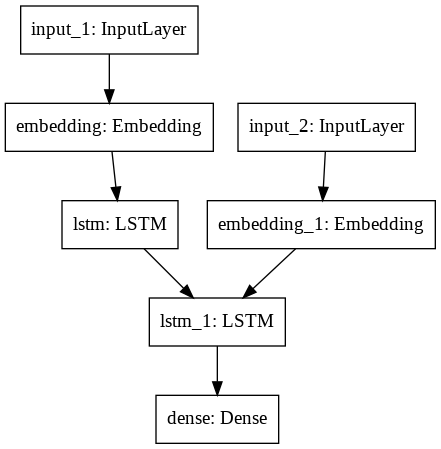

In [22]:
plot_model(model)

In [32]:
X_train = [np.array(x) for x in X_train]
print(X_train[:5])

[array([1, 4, 5, 2]), array([ 1,  4,  5,  6,  7,  8,  9, 10,  2]), array([ 1,  4,  5,  6, 11,  2]), array([ 1,  4,  5,  6, 12, 13,  2]), array([ 1,  4,  5,  6, 12, 13,  8,  2])]


In [30]:
Y_train = [np.array(y) for y in Y_train]
print(Y_train[:5])

[array([1, 4, 5, 2]), array([1, 4, 5, 6, 7, 4, 5, 8, 9, 2]), array([ 1, 10,  5, 11, 12, 13,  2]), array([ 1,  4,  5,  6, 10, 14,  2]), array([ 1,  4,  5,  6, 10, 14,  4,  5,  2])]


In [35]:
# Compile & run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
model.fit([X_train[:1], Y_train[:1]], Y_train[:1],
           batch_size=1,
           epochs=10,
           validation_split=0.2)

Epoch 1/10


ValueError: ignored

# Romanized

In [ ]:
ta_rom = dict()
ta_rom['rejoined'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['rejoined_aligned_cased'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.cased_nopunct.tsv', sep='\t', header=None, error_bad_lines=False) 
ta_rom['rejoined_aligned'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['split'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.split.tsv', sep='\t', header=None, error_bad_lines=False)

b'Skipping line 1096: expected 2 fields, saw 3\nSkipping line 1581: expected 2 fields, saw 3\n'
b'Skipping line 33794: expected 2 fields, saw 3\nSkipping line 33795: expected 2 fields, saw 3\nSkipping line 33796: expected 2 fields, saw 3\nSkipping line 33798: expected 2 fields, saw 3\nSkipping line 33799: expected 2 fields, saw 3\nSkipping line 33801: expected 2 fields, saw 3\nSkipping line 33802: expected 2 fields, saw 3\nSkipping line 33803: expected 2 fields, saw 3\n'
b'Skipping line 11317: expected 2 fields, saw 4\nSkipping line 16502: expected 2 fields, saw 4\nSkipping line 32577: expected 2 fields, saw 3\nSkipping line 32578: expected 2 fields, saw 3\nSkipping line 32579: expected 2 fields, saw 3\nSkipping line 32581: expected 2 fields, saw 3\nSkipping line 32582: expected 2 fields, saw 3\nSkipping line 32584: expected 2 fields, saw 3\nSkipping line 32585: expected 2 fields, saw 3\nSkipping line 32586: expected 2 fields, saw 3\n'
b'Skipping line 1108: expected 7 fields, saw 9\nSk

In [ ]:
list(ta_rom['rejoined'].iloc[0, 0])[:10]

['ர', 'ே', 'ட', 'ி', 'ய', 'ோ', ' ', 'அ', 'த', 'ி']

In [ ]:
ta_rom['rejoined_aligned_cased']

0            1
0            ரேடியோ        radio
1         அதிர்வெண்     athirven
2       முடுக்கிகள்   mudikkigal
3          துகள்கள்    thugalkal
4          நேரடியாக   neradiyaga
...             ...          ...
104779   இவ்விதழின்  ivvithazhin
104780         விலை        vilai
104781       ரூபாய்      roobaay
104782         1.00         1.00
104783         </s>         </s>

[104784 rows x 2 columns]

In [ ]:
ta_rom['rejoined_aligned']

0            1
0             ரேடியோ        Radio
1          அதிர்வெண்     athirven
2       முடுக்கிகள்,  mudikkigal,
3           துகள்கள்    thugalkal
4           நேரடியாக   neradiyaga
...              ...          ...
103538    இவ்விதழின்  ivvithazhin
103539          விலை        vilai
103540        ரூபாய்      roobaay
103541          1.00         1.00
103542          </s>         </s>

[103543 rows x 2 columns]

In [ ]:
ta_rom['split']

0   1  ...   5    6
0     ரேடியோ அதிர்வெண் முடுக்கிகள், துகள்கள் நேரடியா...   6  ... NaN  NaN
1     மான் விளையாடிக்கொண்டு வந்து உன்னை மோதினால் உன்...  21  ... NaN  NaN
2                                             அமிர்தகழி   1  ... NaN  NaN
3     மோகன் லால் குப்தா ஜெய்ப்பூரின் முன்னாள் மேயராக...  12  ... NaN  NaN
4                      தில்லி மாநில கூட்டுறவு வங்கி லி.   5  ... NaN  NaN
...                                                 ...  ..  ...  ..  ...
9982  என்றாலும் வில்லியம் இறந்த பிறகான கரோலினின் பணி...  27  ... NaN  NaN
9983  தொல்பொருளியல் அச்சகம் (Archaeopress) என்பது இங...  14  ... NaN  NaN
9984  மலைய நாட்டு மன்னனை மலாடர் கோமான் என்று சங்கப்ப...   8  ... NaN  NaN
9985  அப்படையின் தொகை மிக அருகி இருந்ததோடு, அதனிடம் ...  12  ... NaN  NaN
9986  தொண்டன் இலங்கை, திருகோணமலையிலிருந்து 1970ம் ஆண...  15  ... NaN  NaN

[9987 rows x 7 columns]